# Exercise Sheet 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split

## [1] Classifiers in sklearn

The aim of this exercise is to familiarise yourself with some of the classifiers implemented in sklearn by applying them to a 2D classification task.  
On the course website you find `classifier_dataset.ipynb` which allows you to generate point-clouds with labels ±1.  
* Using such datasets, build classifiers with `svm.svc`, `DecisionTreeClassifier`, `RandomForestClassifier`, `AdaBoostClassifier`.
* Using default parameters, check their performance on your pointcloud by checking their score and visualising their classification boundaries.
* Comment on how your results for the DecisionTreeClassifier change when varying the `maxdepth`.

### Solution

We first copy the code from the `classifier_dataset.ipynb` file. We could also import it. Furthermore we normalize the data and plot the true class boundaries.

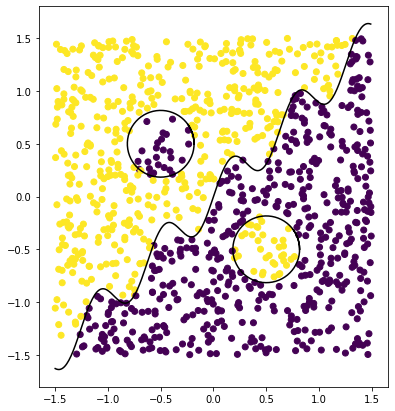

In [2]:
# This defines the wiggly line separating diagonal that we see in the plot below
def con1(x,y):
    if y >= 0.2*np.sin(10*x) + x:
        rv = 1
    else:
        rv = -1
    return rv

# This defines the cloud in the lower right corner of the plot below
def con2(x,y):
    if (x+0.5)**2 + (y-0.5)**2 <= 0.1:
        # return -2 to flip +1 >> -1
        rv = -2
    else:
        rv = 0
    return rv

# This defines the cloud in the upper left corner of the plot below
def con3(x,y):
    if (x-0.5)**2 + (y+0.5)**2 <= 0.1:
        # return +2 to flip -1 >> +1
        rv = 2
    else:
        rv = 0
    return rv

length=1000
xyset = 3.*(np.random.rand(length,2) - [0.5, 0.5])
classes=[con1(xyset[i,0],xyset[i,1])+con2(xyset[i,0],xyset[i,1])+con3(xyset[i,0],xyset[i,1]) for i in range(len(xyset))]

#plt.scatter(xyset[:, 0], xyset[:, 1], c = classes)


# function that plots data with the true boundaries to axes

def plotTrueBoundaries(ax):
    phiRange = np.arange(0,7,0.1)
    xRange = np.arange(-1.5,1.5,0.01)
    x1 = -0.5 + np.sqrt(0.1)*np.cos(phiRange)
    y1 =  0.5 + np.sqrt(0.1)*np.sin(phiRange)
    x2 =  0.5 + np.sqrt(0.1)*np.cos(phiRange)
    y2 = -0.5 + np.sqrt(0.1)*np.sin(phiRange)
    y3 =  0.2*np.sin(10*xRange) + xRange
    ax.plot(x1, y1,'black')
    ax.plot(x2, y2,'black')
    ax.plot(xRange, y3,'black')

plt.figure(figsize = (7,7))
plt.scatter(xyset[:, 0], xyset[:, 1], c = classes)
plotTrueBoundaries(plt.gca())
plt.gca().set_aspect('equal')

We also want to have a function that plots our classification result that we will obtain in the next step to the true boundaries.

In [3]:
def evaluateClassification(xyset, prediction, ax):
    ax.scatter(xyset[:, 0], xyset[:, 1], c = prediction)
    plotTrueBoundaries(ax)
    ax.set_title('Comparison with true class boundaries')
    ax.set_aspect('equal')

For most of the time, we will let the classifiers run on the whole dataset. We also split into training and test sets:

In [4]:
XY_train, XY_test, classes_train, classes_test = train_test_split(xyset, classes, random_state=42)

For the different classifiers, see the sklearn documentation:
* [Support Vector Classification (svm.SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

#### Support Vector Machine

Score:  0.903


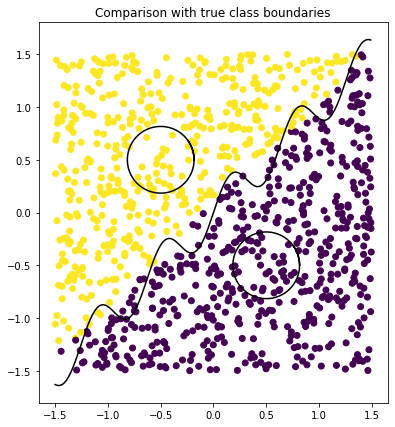

In [5]:
# svm.SVC default settings

svcClass = SVC(gamma='auto')
svcClass.fit(xyset, classes) 
svcPred = svcClass.predict(xyset)

plt.figure(figsize = (7,7))
comp = evaluateClassification(xyset, svcPred, plt.gca())
print('Score: ', svcClass.score(xyset, classes))

Score:  1.0


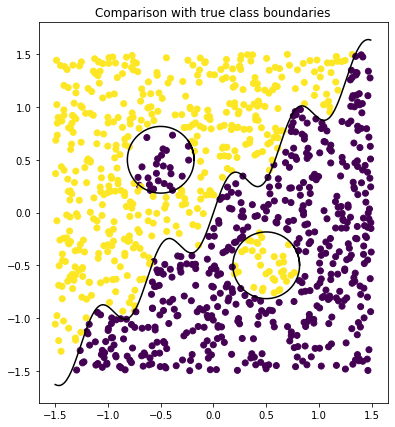

In [6]:
# svm.SVC but now tune gamma

svcClass = SVC(gamma=5000)
svcClass.fit(xyset, classes) 
svcPred = svcClass.predict(xyset)

plt.figure(figsize = (7,7))
comp = evaluateClassification(xyset, svcPred, plt.gca())
print('Score: ', svcClass.score(xyset, classes))

The SVM classifier is using an RBF kernel internally (as discussed in the tutorial). This has a scale $\gamma$ associated to it. It is a good idea to scan over this parameter. We see that for large $\gamma$ we can easily reproduce the true class boundaries if we train on the full dataset. But...

In [7]:
# svm.SVC with large gamma and train_test_split

svcClass = SVC(gamma=5000)
svcClass.fit(XY_train, classes_train) 
svcPred = svcClass.predict(XY_test)

print('Score: ', svcClass.score(XY_test, classes_test))

Score:  0.616


This shows us that significant overfitting is happening.

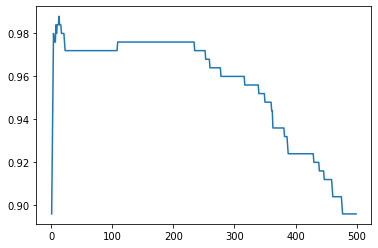

In [8]:
max_gamma=500
scores = np.zeros(max_gamma-1)

for i in range(1,max_gamma):
    svcClass = SVC(gamma=i)
    svcClass.fit(XY_train, classes_train) 
    svcPred = svcClass.predict(XY_test)
    scores[i-1]=svcClass.score(XY_test, classes_test)

plt.plot(range(1,max_gamma),scores)

We see that there is an optimal value for $\gamma$.

In [9]:
gamma_opt = scores.argmax()+1
print(gamma_opt)

13


#### Decision Tree

Score:  1.0


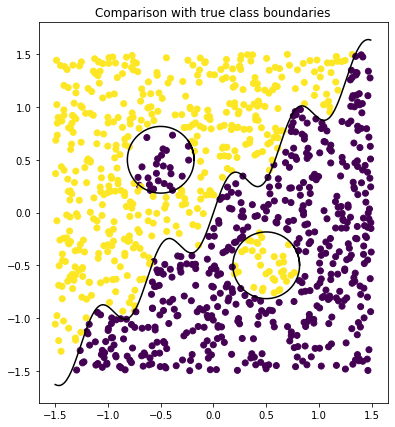

In [10]:
# DecisionTreeClassifier

DecTreeClass = DecisionTreeClassifier(max_depth=20)
DecTreeClass.fit(xyset, classes) 
DecTreePred = DecTreeClass.predict(xyset)

plt.figure(figsize = (7,7))
comp = evaluateClassification(xyset, DecTreePred, plt.gca())
print('Score: ', DecTreeClass.score(xyset, classes))

Let's see how the performance of DecisionTreeClassifier changes with `maxdepth`

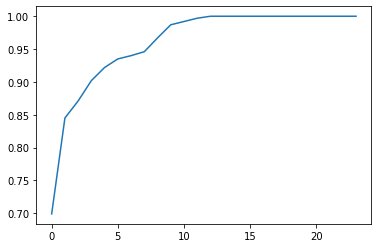

In [11]:
# Save the score
scores = np.array([])

for maxdepth in range(1, 25):
    DecTreeClass = DecisionTreeClassifier(max_depth = maxdepth)
    DecTreeClass.fit(xyset, classes) 
    DecTreePred = DecTreeClass.predict(xyset)
    scores = np.append(scores, DecTreeClass.score(xyset, classes))

_ = plt.plot(scores)

We see that the score saturates qickly and is approximately 1 at `max_depth=10` and greater. If `max_depth` is low, we can see the linear classification boundaries.

Score:  0.922


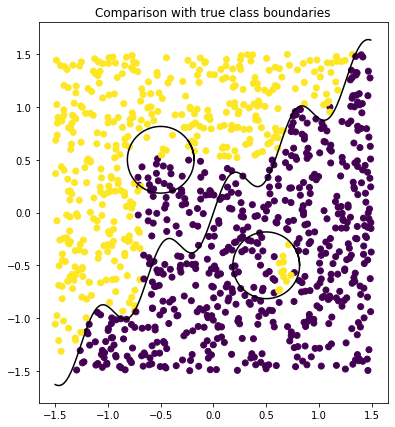

In [12]:
DecTreeClass = DecisionTreeClassifier(max_depth=5)
DecTreeClass.fit(xyset, classes) 
DecTreePred = DecTreeClass.predict(xyset)

plt.figure(figsize = (7,7))
comp = evaluateClassification(xyset, DecTreePred, plt.gca())
print('Score: ', DecTreeClass.score(xyset, classes))

#### Random Forest

Score:  1.0


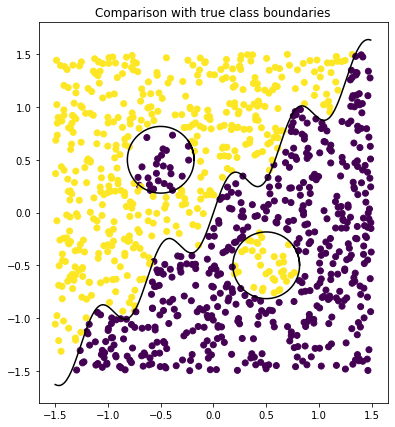

In [13]:
# RandomForestClassifier

RndFrstClass = RandomForestClassifier()
RndFrstClass.fit(xyset, classes) 
RndFrstPred = RndFrstClass.predict(xyset)

plt.figure(figsize = (7,7))
comp = evaluateClassification(xyset, RndFrstPred, plt.gca())
print('Score: ', RndFrstClass.score(xyset, classes))

Score:  1.0


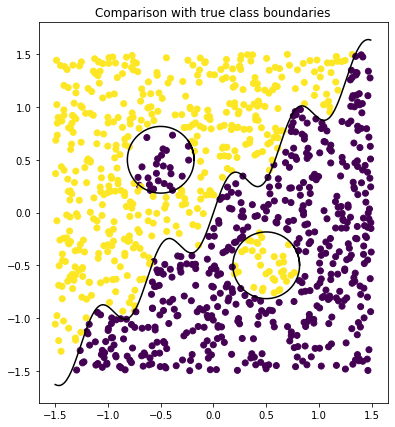

In [14]:
# RandomForestClassifier

RndFrstClass = RandomForestClassifier(max_depth=200)
RndFrstClass.fit(xyset, classes) 
RndFrstPred = RndFrstClass.predict(xyset)

plt.figure(figsize = (7,7))
comp = evaluateClassification(xyset, RndFrstPred, plt.gca())
print('Score: ', RndFrstClass.score(xyset, classes))

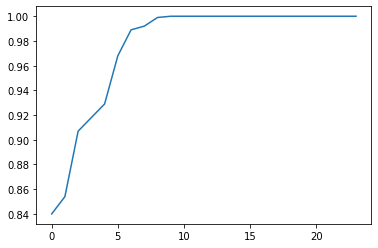

In [15]:
# Save the score
scores = np.array([])

for maxdepth in range(1, 25):
    RFClass = RandomForestClassifier(max_depth = maxdepth)
    RFClass.fit(xyset, classes) 
    RFPred = DecTreeClass.predict(xyset)
    scores = np.append(scores, RFClass.score(xyset, classes))

_ = plt.plot(scores)

#### AdaBoost

Score:  0.93


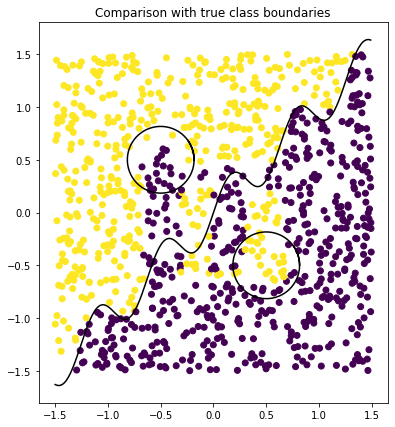

In [16]:
# AdaBoostClassifier

AdaBstClass = AdaBoostClassifier()
AdaBstClass.fit(xyset, classes) 
AdaBstPred = AdaBstClass.predict(xyset)

plt.figure(figsize = (7,7))
comp = evaluateClassification(xyset, AdaBstPred, plt.gca())
print('Score: ', AdaBstClass.score(xyset, classes))

Score:  1.0


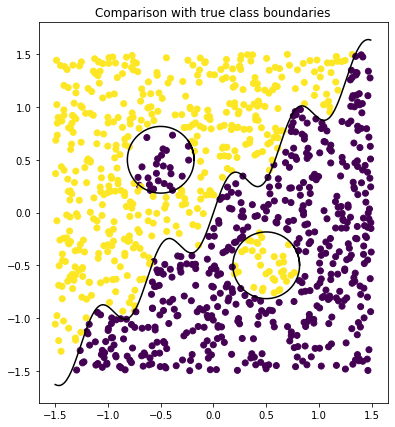

In [17]:
# AdaBoostClassifier

AdaBstClass = AdaBoostClassifier(n_estimators=5000)
AdaBstClass.fit(xyset, classes) 
AdaBstPred = AdaBstClass.predict(xyset)

plt.figure(figsize = (7,7))
comp = evaluateClassification(xyset, AdaBstPred, plt.gca())
print('Score: ', AdaBstClass.score(xyset, classes))

We see that for AdaBoost the relevant hyperparameter to tune is `n_estimators`. 

In [18]:
# AdaBoostClassifier

AdaBstClass = AdaBoostClassifier(n_estimators=5000)
AdaBstClass.fit(XY_train, classes_train) 
AdaBstPred = AdaBstClass.predict(XY_test)

print('Score: ', AdaBstClass.score(XY_test, classes_test))

Score:  0.92


Again, crazy values perform well on the full dataset, but if we split into training and test, there will be an optimal value due to the bias-variance tradeoff.